In [158]:
import numpy as np
import pandas as pd
from preprocess import Preprocess
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

In [159]:
PCA_COMPONENTS = 4
IMAGE_RESIZE = (64, 64)
TRANSFORM = transforms.Compose([
    transforms.Resize(IMAGE_RESIZE),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mean(dim=0)), # gray
    transforms.Lambda(lambda x: x.view(-1)) # flatten
])
train_data = Preprocess.load_train_people(shuffle=True, seed=0, transform=TRANSFORM)

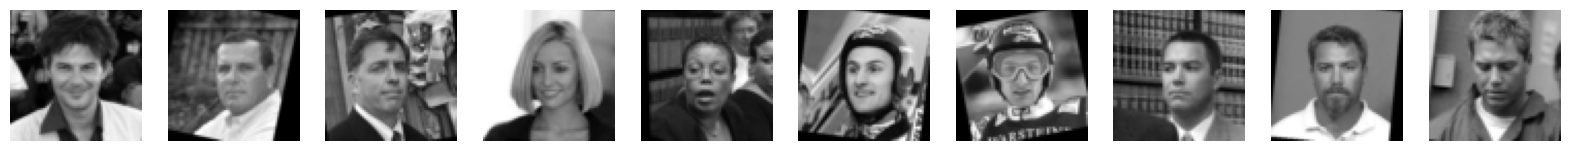

In [160]:
def plot_images(data, n: int):
    _, axs = plt.subplots(1, n, figsize=(20, 4))
    for i, image in enumerate(data):
        if i >= n:
            break
        # Unflatten image
        image = image.view(IMAGE_RESIZE)
        axs[i].imshow(image, cmap='gray')
        axs[i].axis('off')
    plt.show()

plot_images(train_data, n=10)

In [161]:
image_shape = next(iter(train_data)).shape
print(f'Image tensor shape:', image_shape)

Image tensor shape: torch.Size([4096])


In [162]:
train_in_memory = torch.stack([image for image in train_data])
train_in_memory.shape

torch.Size([9525, 4096])

In [163]:
pca = PCA(n_components=PCA_COMPONENTS)
projected_train_data = pca.fit_transform(train_in_memory)
projected_train_data.shape

(9525, 4)

In [164]:
pca.explained_variance_ratio_.sum() 

0.42757502792494473

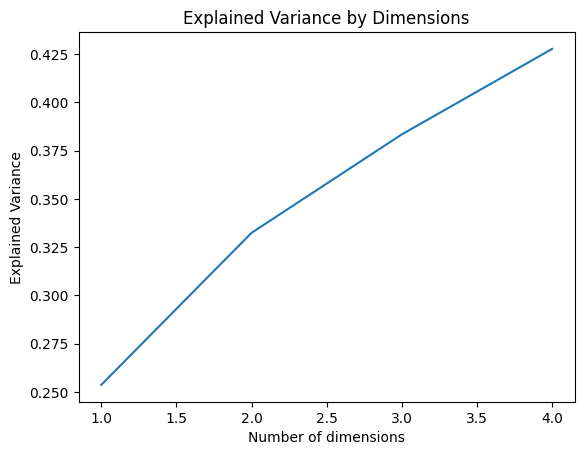

In [165]:
plt.plot(range(1, projected_train_data.shape[1] + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of dimensions')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Dimensions')
plt.show()

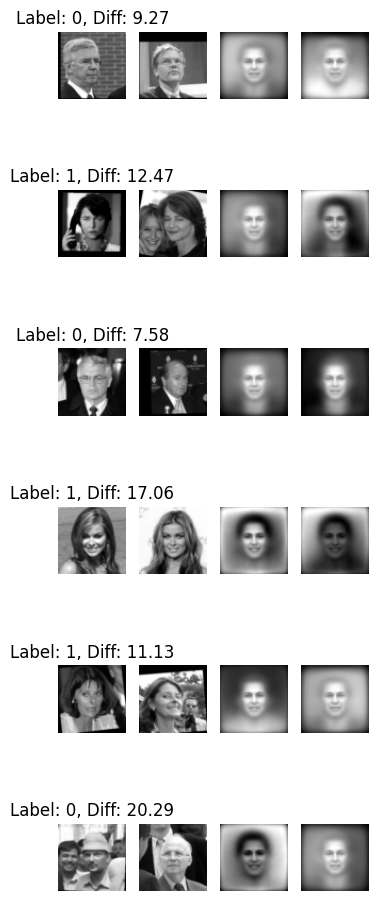

In [166]:
# Show the first 2 images
def compare(pair_dataset, nrows):
    _, axs = plt.subplots(nrows, 4, figsize=(4, 2 * nrows))
    indices = np.random.choice(len(pair_dataset), nrows, replace=False)
    for i, pair_index in enumerate(indices):
        image1, image2, label = pair_dataset.__getitem__(pair_index)
        proj1 = pca.transform(image1.reshape(1, -1))[0]
        proj2 = pca.transform(image2.reshape(1, -1))[0]
        image1 = image1.view(IMAGE_RESIZE)
        image2 = image2.view(IMAGE_RESIZE)
        axs[i][0].set_axis_off()
        axs[i][1].set_axis_off()
        axs[i][0].imshow(image1, cmap='gray')
        axs[i][1].imshow(image2, cmap='gray')

        # Reconstructed images
        invproj1 = pca.inverse_transform(proj1)
        invproj2 = pca.inverse_transform(proj2)
        invproj1 = invproj1.reshape(IMAGE_RESIZE)
        invproj2 = invproj2.reshape(IMAGE_RESIZE)
        axs[i][2].set_axis_off()
        axs[i][3].set_axis_off()
        axs[i][2].imshow(invproj1, cmap='gray')
        axs[i][3].imshow(invproj2, cmap='gray')

        diff = np.linalg.norm(proj1 - proj2)
        axs[i][0].set_title(f'Label: {label}, Diff: {diff:.2f}')

compare(Preprocess.load_train_pairs(transform=TRANSFORM), nrows=6)

In [167]:
def check_accuracy(threshold, pair_data_loader):
    correct = 0
    for image1, image2, label in pair_data_loader:
        proj1 = pca.transform(image1.reshape(1, -1))[0]
        proj2 = pca.transform(image2.reshape(1, -1))[0]
        image1 = image1.view(IMAGE_RESIZE)
        image2 = image2.view(IMAGE_RESIZE)
        diff = np.linalg.norm(proj1 - proj2)
        decision = int(diff < threshold)
        correct += int(decision == label)
    accuracy = correct / len(pair_data_loader)
    return accuracy

In [168]:
thresholds = [18, 19, 20, 21, 22] # you may have to change these values
train_acc = []
test_acc = []

for threshold in thresholds:
    train_accuracy = check_accuracy(threshold, Preprocess.load_train_pairs(transform=TRANSFORM))
    test_accuracy = check_accuracy(threshold, Preprocess.load_test_pairs(transform=TRANSFORM))
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

df = pd.DataFrame({'train_acc': train_acc, 'test_acc': test_acc}, index=thresholds)
df

,train_acc,test_acc
18,0.540455,0.538
19,0.536364,0.529
20,0.525909,0.518
21,0.519545,0.513
22,0.516818,0.510


In [171]:
# Save PCA
import pickle
with open(f'trained/pca/pca{pca.n_components_}.pkl', 'wb') as f:
    pickle.dump(pca, f)